In [1]:
from ordered_set import OrderedSet
from six.moves import cPickle as pickle 
from collections import defaultdict
from scipy.sparse import load_npz
from scipy.sparse import csr_matrix

import numpy as np
import torch
import torch_geometric
import networkx as nx

from torch_geometric.nn import SAGEConv, ChebConv, TAGConv, GATConv, ARMAConv, BatchNorm
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve

import random

from torch_geometric.data import ClusterData, ClusterLoader

class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, hidden_size1, hidden_size2, hidden_size3, num_classes, conv):
        super(GCN, self).__init__()
        self.conv1 = conv(in_feats, hidden_size)
        self.bn1 = BatchNorm(hidden_size)
        self.conv2 = conv(hidden_size, hidden_size1)
        self.bn2 = BatchNorm(hidden_size1)
        self.conv3 = conv(hidden_size1, hidden_size2)
        self.bn3 = BatchNorm(hidden_size2)
        self.conv4 = conv(hidden_size2, hidden_size3)
        self.bn4 = BatchNorm(hidden_size3)
        self.conv5 = conv(hidden_size3, num_classes)
        self.bn5 = BatchNorm(num_classes)
        x = 10
        self.encoder = nn.Sequential(
            nn.Conv2d(1, x, (3, 3)),
            nn.LeakyReLU(),
            nn.Dropout2d(),
            nn.Conv2d(x, 2*x, (3, 2)),
            nn.LeakyReLU(),
            nn.Dropout2d(),
            nn.Conv2d(2*x, 1, (3, 2)),
        )

    def forward(self, edge_index, x):
        h = self.encoder(x.reshape(-1, 1, 100, 5)).reshape(-1, 94)
        h = torch.tanh(h)
        h = F.dropout(h, training=self.training)
        h = self.conv1(h, edge_index)
        h = self.bn1(h)
        h = torch.tanh(h)
        h = F.dropout(h, training=self.training)
        h = self.conv2(h, edge_index)
        h = self.bn2(h)
        h = torch.tanh(h)
        h = F.dropout(h, training=self.training)
        h = self.conv3(h, edge_index)
        h = self.bn3(h)
        h = torch.tanh(h)
        h = F.dropout(h, training=self.training)
        h = self.conv4(h, edge_index)
        h = self.bn4(h)
        h = torch.tanh(h)
        h = F.dropout(h, training=self.training)
        h = self.conv5(h, edge_index)
        h = self.bn5(h)
        h = F.softmax(h, dim=1)
        return h

In [2]:
def train_model(net, data_loader, epochs, learning_rate, train_mask, test_mask, mask):
    device = torch.device('cuda')
    model = net.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    losses_train = []
    losses_test = []
    auc_l = []    
    best_auc = -1

    pbar = tqdm(range(epochs))
    for epoch in pbar:
        logits = []
        y = []
        mask = []
        train_mask = []
        test_mask = []
        for d in data_loader:
            d = d.to(device)
            model.train()

            local_logits = model(edge_index=d.edge_index, x=d.x.float())
            logits.append(local_logits)
            y.append(d.y)
            local_mask = (d.y != -1)
            mask.append(local_mask)

            local_logits = local_logits[local_mask]
            local_y = d.y[local_mask]

            x = int(local_logits.shape[0] * 0.8)
            local_train_mask = [True if i < x else False for i in range(local_logits.shape[0])]
            local_test_mask = [False if i < x else True for i in range(local_logits.shape[0])]
            train_mask += local_train_mask
            test_mask += local_test_mask
            
            loss = F.cross_entropy(local_logits[:x], local_y[:x])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        logits = torch.cat(logits, dim=0).to(device)
        y = torch.cat(y, dim=0)
        mask = torch.cat(mask, dim=0)
        
        logits = logits[mask]
        y = y[mask]
        
        loss = F.cross_entropy(logits[train_mask], y[train_mask])
        loss_test = F.cross_entropy(logits[test_mask], y[test_mask])
        losses_train.append(loss.item())
        losses_test.append(loss_test.item())

        model.eval()
        pred = list(map(lambda x: np.argmax(x, axis = 0), torch.exp(F.log_softmax(logits, 1)).cpu().detach().numpy()))
        auc = roc_auc_score(y[test_mask].cpu().numpy(), torch.tensor(pred).long()[test_mask], average='weighted')
        auc_l.append(auc)
        best_auc = best_auc if best_auc > auc else auc

        pbar.set_description('Best Test AUC: %.4f | Train Loss: %.4f | Test Loss: %.4f' % (best_auc, loss.item(), loss_test.item()))

    return model

In [3]:
def run_sim(cl, batches, layer):
    layer_dict = {
        'arma': ARMAConv,
        'sage': SAGEConv,
        'tag': TAGConv
    }
    mat = load_npz('/gpfs/data/rsingh47/jbigness/data/%s/hic_sparse_vcsqrt_oe_edge_v9.npz' % cl)
    hms = np.load('/gpfs/data/rsingh47/jbigness/data/%s/np_hmods_norm_vcsqrt_oe_edge_v9.npy' % cl)
    labs = np.load('/gpfs/data/rsingh47/jbigness/data/%s/np_nodes_lab_genes_vcsqrt_oe_edge_v9.npy' % cl)
    
    print('Data Loaded')
    
    mask = torch.tensor(labs[:,-1]).long()
    loc = {}
    for i in range(labs[:, -1].shape[0]):
        loc[labs[i, -1]] = i
    y = []
    for i in range(mat.shape[0]):
        y.append(labs[loc[i],-2]) if i in mask else y.append(-1)
    y = torch.tensor(y).long()
    extract = torch_geometric.utils.from_scipy_sparse_matrix(mat)
    G = torch_geometric.data.Data(edge_index = extract[0], 
                                  edge_attr = extract[1], 
                                  x = torch.tensor(hms).float().reshape(-1, 1, 100, 5), 
                                  y = y)
    
    cluster_data = ClusterData(G, num_parts=batches, recursive=False)
    train_loader = ClusterLoader(cluster_data, batch_size=2, shuffle=False,
                             num_workers=0)
    
    print('Data Clustered')
    
    random.seed(30)
    idx = list(range(labs.shape[0] - 1))
    random.shuffle(idx)
    train_mask = idx[:10000]
    test_mask = idx[10000:]
    
    net = GCN(94, 750, 450, 200, 50, 2, layer_dict[layer])
    return train_model(net, train_loader, 200, 0.0005, train_mask, test_mask, mask)

In [4]:
model = run_sim('E116', 80, 'sage')

Data Loaded
Computing METIS partitioning...
Done!
Data Clustered


Best Test AUC: 0.8190 | Train Loss: 0.4912 | Test Loss: 0.4902: 100%|██████████| 200/200 [13:05<00:00,  3.93s/it]


In [5]:
from torch_geometric.nn import GNNExplainer

In [19]:
explainer = GNNExplainer(model, epochs = 25000)

In [20]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import sqrt
from matplotlib.pyplot import figure
%matplotlib inline
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import robust_scale

def plot_node_exp(explainer, node_idx, data, thresh, node_feat_mask = None, edge_mask = None, neighbors = False):
    if node_feat_mask is None:
        node_feat_mask, edge_mask = explainer.explain_node(node_idx, data.x.reshape(data.x.shape[0], -1), data.edge_index)
    
    edges_sub = []
    for i in range(len(edge_mask)):
        if edge_mask[i] > thresh:
            edges_sub.append(i)
    new_edge_mask = edge_mask[edges_sub]
    new_edges_index = data.edge_index.t()[edges_sub].t()
    
    kwargs = {}
    if neighbors:
        kwargs['font_size'] = 3
        kwargs['node_size'] = 400
        n = new_edges_index[0].cpu().numpy()
        for node in n:
            nfm, em = explainer.explain_node(node.item(), data.x.reshape(data.x.shape[0], -1), data.edge_index)
            edges_sub = []
            for i in range(len(em)):
                if em[i] > thresh:
                    edges_sub.append(i)
            new_edge_mask = torch.cat([new_edge_mask, em[edges_sub]], dim=-1)
            new_edges_index = torch.cat([new_edges_index, data.edge_index.t()[edges_sub].t()], dim = -1)
    else:
        kwargs['font_size'] = kwargs.get('font_size') or 6
        kwargs['node_size'] = kwargs.get('node_size') or 800
    
    G = nx.DiGraph()
    for i in range(new_edges_index.shape[1]):
        G.add_edge(new_edges_index[0][i].item(), new_edges_index[1][i].item(), weight=new_edge_mask[i].item())
    new_y = data.y[list(G.nodes)]
    
    kwargs['with_labels'] = kwargs.get('with_labels') or True
    kwargs['cmap'] = kwargs.get('cmap') or 'coolwarm'

    pos = nx.spring_layout(G)
    fig, ax = plt.subplots(figsize=(8, 8), dpi=250, frameon=False)
    ax.axis('off')
    spec = mpl.gridspec.GridSpec(ncols=2, nrows=3, figure=fig, height_ratios=[6, 1, 0.2], width_ratios=[.8, .15], wspace = 0.0)
    ax1 = fig.add_subplot(spec[0, :])
    ax2 = fig.add_subplot(spec[1, 0])
    ax3 = fig.add_subplot(spec[2, 0])
    ax4 = fig.add_subplot(spec[1, 1])
    ax5 = fig.add_subplot(spec[2, 1])
    ax1.axis('off')
    ax5.axis('off')
    fig.suptitle('%s: Edge and HM Importance for %s (%s)' % ('E116', 'Node %d' % node_idx, 'Up' if data.y[node_idx].item() == 1 else 'Down'))
    for source, target, data in G.edges(data=True):
        ax1.annotate(
            '', xy=pos[target], xycoords='data', xytext=pos[source],
            textcoords='data', arrowprops=dict(
                arrowstyle="->",
                alpha=max(float(data['weight']), 0.1),
                shrinkA=sqrt(kwargs['node_size']) / 2.0,
                shrinkB=sqrt(kwargs['node_size']) / 2.0,
                connectionstyle="arc3,rad=0.1",
            ))
    nx.draw_networkx_nodes(G, pos, ax=ax1, node_color=new_y.tolist(), label='Expression', **kwargs)
    nx.draw_networkx_labels(G, pos, ax=ax1, **kwargs)
    a = node_feat_mask.reshape(5, 100).cpu().numpy()
    new_matrix = robust_scale(a.flatten(), with_centering = True).reshape(5, 100)
    df = pd.DataFrame(new_matrix)
    df.index = ['H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me3', 'H3K9me3']
    ax2 = sns.heatmap(df, ax=ax2, yticklabels = df.index, xticklabels=False, cmap="coolwarm", cbar_ax = ax3, cbar_kws={"orientation": "horizontal", 'label': 'Importance Score'})
    ax4 = sns.barplot(x = df.sum(axis=1), y = df.index, ax = ax4)
    ax4.axis('off')
    return node_feat_mask, edge_mask, G, fig

In [21]:
node_feat_mask, edge_mask = None, None

In [22]:
cl = 'E116'

mat = load_npz('/gpfs/data/rsingh47/jbigness/data/%s/hic_sparse_vcsqrt_oe_edge_v9.npz' % cl)
hms = np.load('/gpfs/data/rsingh47/jbigness/data/%s/np_hmods_norm_vcsqrt_oe_edge_v9.npy' % cl)
labs = np.load('/gpfs/data/rsingh47/jbigness/data/%s/np_nodes_lab_genes_vcsqrt_oe_edge_v9.npy' % cl)

mask = torch.tensor(labs[:,-1]).long()
loc = {}
for i in range(labs[:, -1].shape[0]):
    loc[labs[i, -1]] = i
y = []
for i in range(mat.shape[0]):
    y.append(labs[loc[i],-2]) if i in mask else y.append(-1)
y = torch.tensor(y).long()
extract = torch_geometric.utils.from_scipy_sparse_matrix(mat)
data = torch_geometric.data.Data(edge_index = extract[0], 
                              edge_attr = extract[1], 
                              x = torch.tensor(hms).float().reshape(-1, 1, 100, 5), 
                              y = y)
data = data.to('cuda')

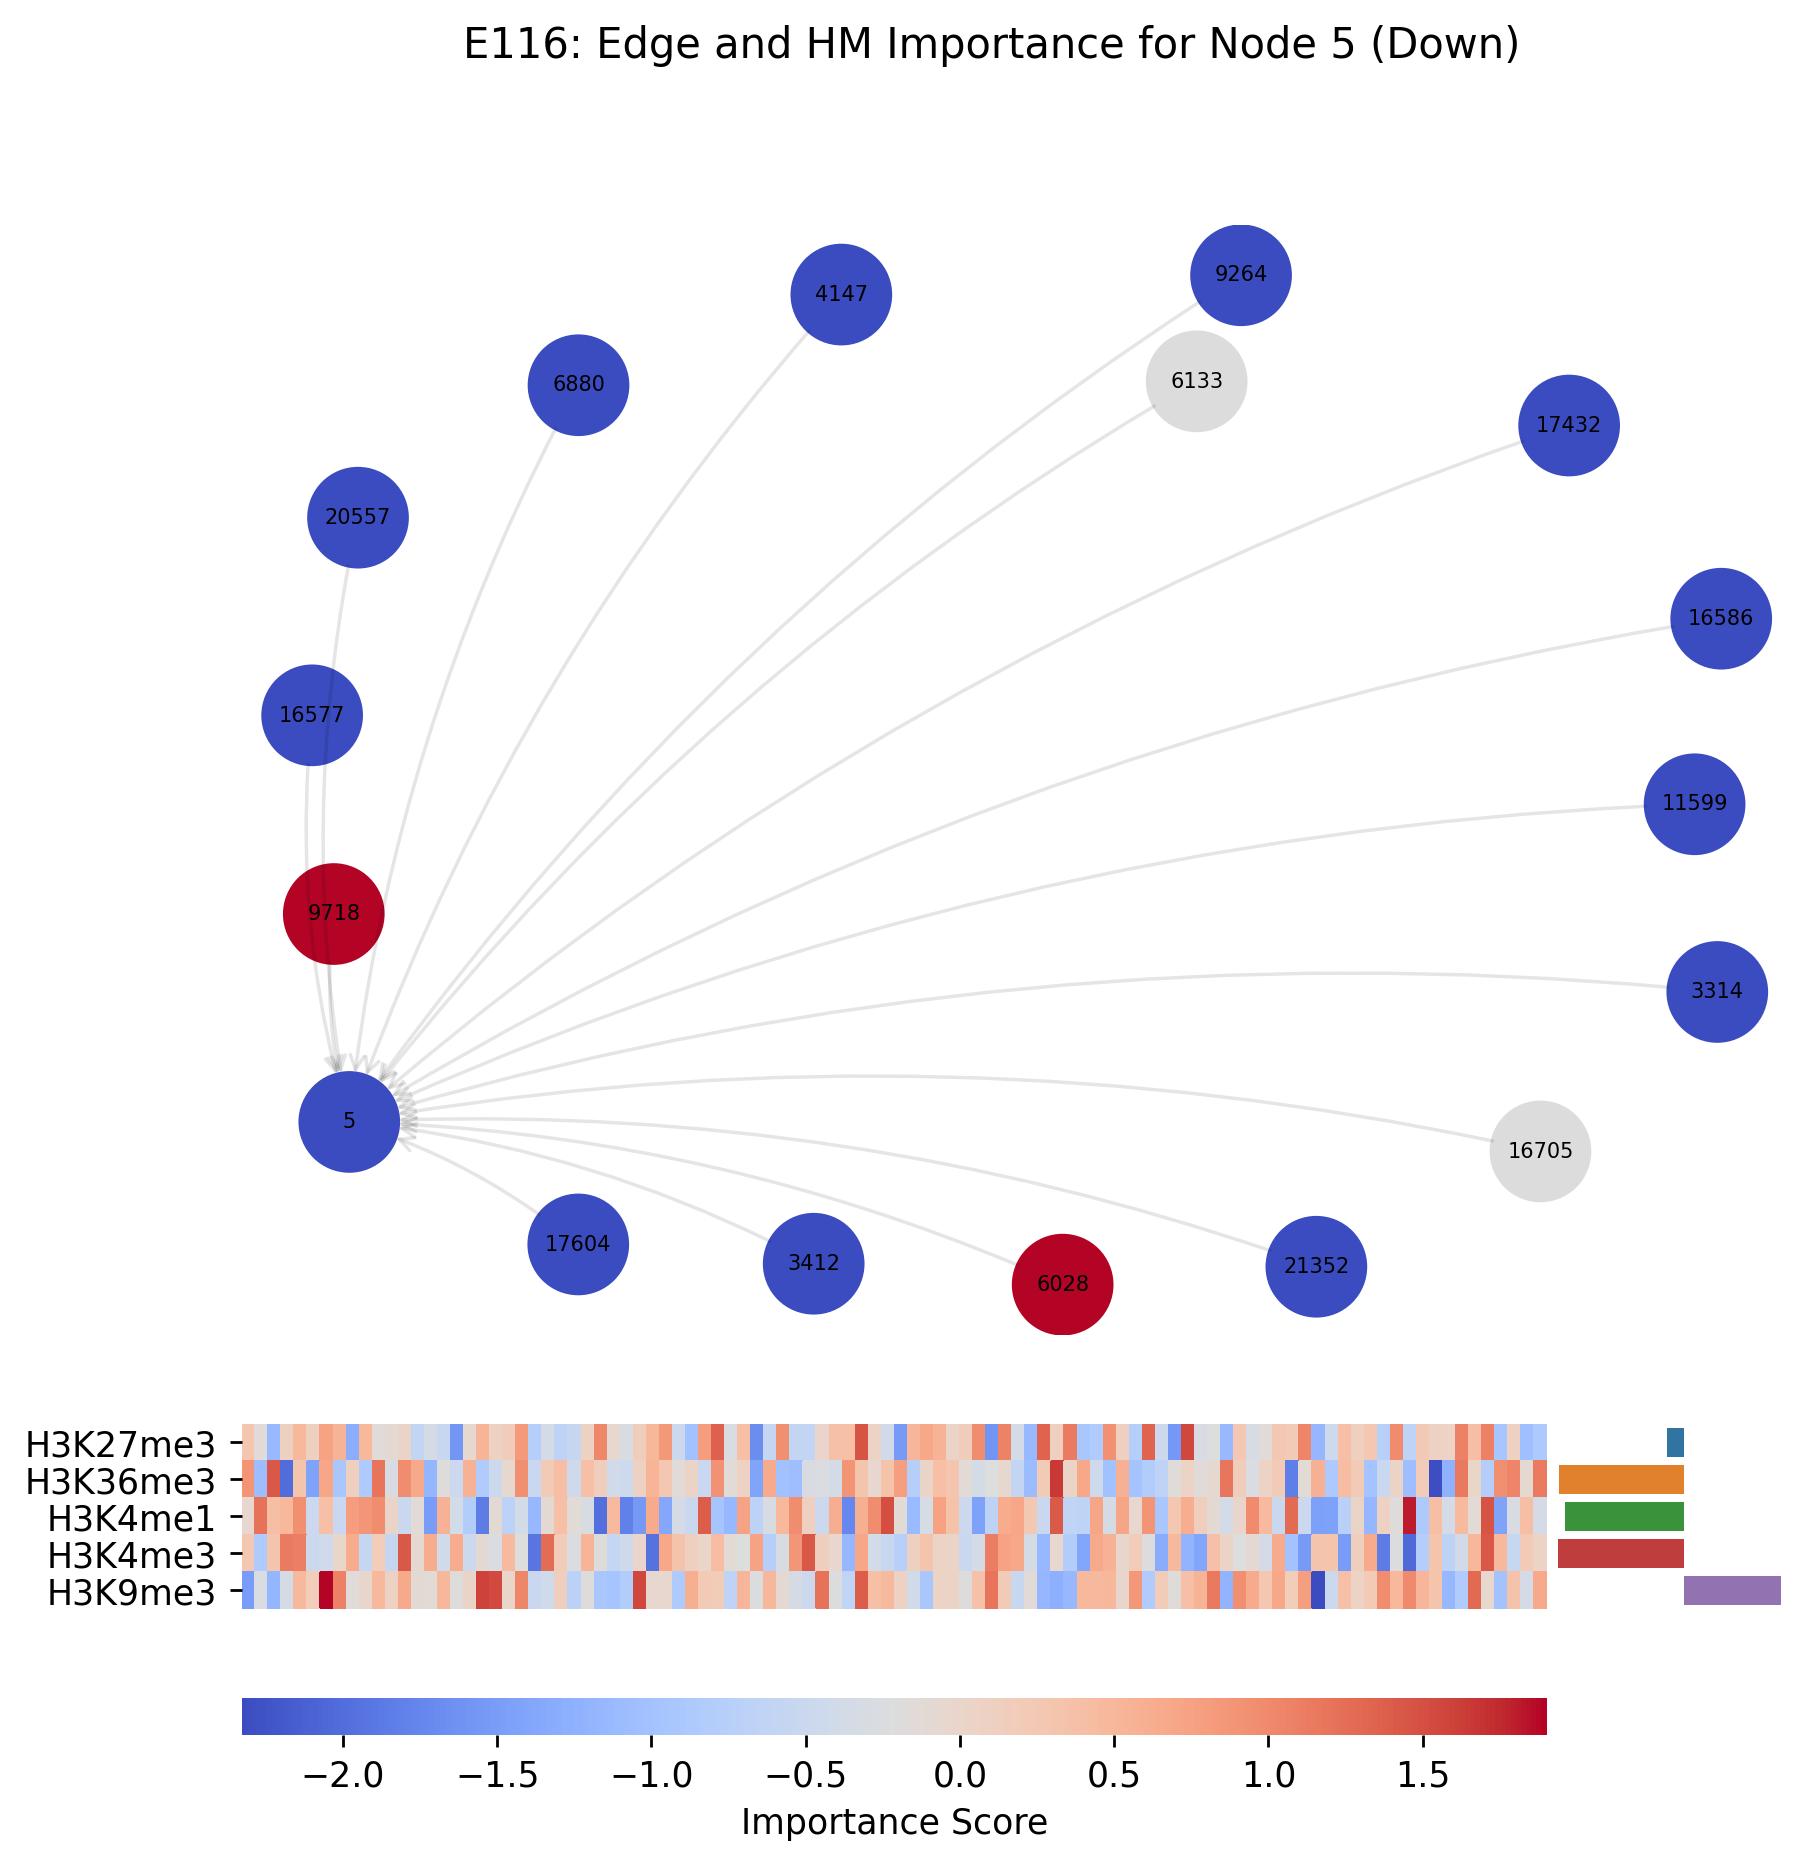

In [26]:
node_feat_mask, edge_mask, _, _ = plot_node_exp(explainer, 5, data, 0.0000000785, node_feat_mask, edge_mask, False)

In [25]:
edge_mask.sort()

torch.return_types.sort(
values=tensor([0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 7.8929e-08, 7.9110e-08,
        7.9611e-08], device='cuda:0'),
indices=tensor([952272, 952273, 952274,  ..., 437262, 767263, 155790], device='cuda:0'))